# FarmVibes.AI Crop Segmentation

This notebook demonstrates how to train a neural network to segment crops on NDVI timeseries and [Crop Data Layer](https://data.nal.usda.gov/dataset/cropscape-cropland-data-layer#:~:text=The%20Cropland%20Data%20Layer%20%28CDL%29%2C%20hosted%20on%20CropScape%2C,as%20well%20as%20boundary%2C%20water%20and%20road%20layers.) (CDL) maps provided by FarmVibes.AI platform.

As provided, the notebook retrieves and preprocesses a region of ~5,000 km² over a 1-year period. **We recommend having at least 500 GB of disk space available. The workflow may take multiple days to run, depending on the number of workers and your VM spec.**


### Conda environment setup
Before running this notebook, let's build a conda environment. If you do not have conda installed, please follow the instructions from [Conda User Guide](https://docs.conda.io/projects/conda/en/latest/user-guide/index.html). 

```
$ conda env create -f ./crop_env.yaml
$ conda activate crop-seg
```

### Notebook outline
The user provides a geographical region and a date range of interest, which are used as input to a FarmVibes.AI workflow that generates the dataset for this task. The workflow consists of downloading and preprocessing Sentinel-2 data, running SpaceEye to obtain cloud-free imagery, and computing daily NDVI indexes at 10m resolution. It also downloads CDL maps in the same time frame at 30m resolution, upsampling them to 10m resolution via nearest neighbor interpolation to be used as ground-truth labels.   

As each CDL map represents a single year, we combine multiple NDVI rasters along the year, stacking in the channel dimension a number of rasters equal to `NDVI_STACK_BANDS`. In this notebook, we set `NDVI_STACK_BANDS = 37`, which means a 10-day interval between each ndvi raster of a year. During training, we extract chips/patches from the NDVI stacks and CDL maps.  


Below are the main libraries used for this example and other useful links:
- [Pytorch](https://github.com/pytorch/pytorch) is used as our deep learning framework.
- [TorchGeo](https://github.com/microsoft/torchgeo) is a library built for training models on geospatial data. We use it to dinamically sample fixed-sized chips to train/evaluate our model. We define torchgeo dataset at lib/datasets.py
- [Pytorch-Lightning](https://github.com/Lightning-AI/lightning) is wrapper over pytorch to reduce boilerplate code for training and evaluating models. We define lightning modules at lib/modules.py.
- [Shapely](https://github.com/shapely/shapely) is a library for manipulating geometric shapes.
- [Geopandas](https://github.com/geopandas/geopandas) is an extension of the popular pandas library to add support for geographic data. It uses shapely objects in its geometry column, and understands coordinate systems. We use it to visualize the training/validation RoIs. It is also quite useful for transforming geometries between different CRSs.
- [xarray](https://github.com/pydata/xarray) and the extension [rioxarray](https://github.com/corteva/rioxarray) are used for merging and visualizing predictions.
- [rasterio](https://github.com/rasterio/rasterio) is a library for reading and writing geospatial raster data. It is used on torchgeo and rioxarray. It is a good option when reading/writing GeoTIFFs.
- [onnx](https://onnx.ai/get-started.html) is a library for exporting machine learning models to a interoperable format. 

### Code organization
The training code is mainly organized into four parts:

- The datasets (`notebook_lib/datasets.py`) inherit from torchgeo's `RasterDataset` and are used to read and preprocess the CDL and NDVI data produced by FarmVibes.AI platform. For those familiar with pytorch, these datasets are indexed by a spatiotemporal bounding box instead of integer. If you want to add new datasets, you can use these as a base (and check [torchgeo documentation](https://torchgeo.readthedocs.io/en/latest/)).
- The lightning data module (`notebook_lib/modules.py`) contains the code for samplers and data loaders. If you want to change the data split, how to load data, which crops to use, this is probably where you should go to. Also check [pytorch-lightning documentation](https://pytorch-lightning.readthedocs.io/en/latest/).
- The lightning module (`notebook_lib/models.py`) contains the code for running/training/evaluating the neural network: instantiating the neural network, training steps, computing metrics, and others. If you want to change the architecure, the loss, and generally how the model is trained, this is probably where you should go to. Also check [pytorch-lightning documentation](https://pytorch-lightning.readthedocs.io/en/latest/).
- Two utility subpackages (`notebook_lib/utils.py` and `notebook_lib/constants.py`) with supporting code for monitoring the workflow execution, defining crop indexes constants, etc.

### Imports & Constants

In [1]:
# Utility imports
from datetime import datetime
from shapely import wkt
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rioxarray as rio
import os
from tqdm.notebook import tqdm
import xarray as xr
from rioxarray.merge import merge_arrays


# FarmVibes.AI imports
from vibe_core.client import get_default_vibe_client

# Pytorch-related imports
import torch
from torchgeo.datasets import BoundingBox
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
import onnx

# Imports for this example notebook 
from notebook_lib.utils import bbox_to_shapely, format_timestamp
from notebook_lib.modules import CropSegDataModule
from notebook_lib.models import SegmentationModel
import notebook_lib.constants as constants


##### CONSTANTS
# FarmVibes.AI workflow name and description
WORKFLOW_NAME = "ml/dataset_generation/datagen_crop_segmentation"
RUN_NAME = "dataset generation for crop segmentation task"

# Dataloader / Model parameters
ROOT_DIR = "./model_checkpoint"

# Leave empty to train
CHPT_PATH = ""
# Add path to load checkpoint
# CHPT_PATH = "notebooks/crop_segmentation/model_checkpoint/lightning_logs/version_0/checkpoints/epoch=9-step=320.ckpt"

CHIP_SIZE = 256
EPOCH_SIZE = 1024
BATCH_SIZE = 16
NDVI_STACK_BANDS = 37
NUM_WORKERS = 1  # Change this depending on available memory and number of cores

# Training hyperparameters
LR = 1e-3  # Learning rate
WD = 1e-2  # Weight decay
MAX_EPOCHS = 20  # How many epochs to train for

/home/azureuser/anaconda3/envs/crop-seg/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/azureuser/anaconda3/envs/crop-seg/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


### Generate the dataset with FarmVibes.AI platform

Let's define the region and the time range to consider for this task:
- **Region:** FarmVibes.AI platform expects a `.wkt` file with the polygon of the ROI (an example `input_region.wkt` is already provided);
- **Time Range:** we define the range as a tuple with two datetimes (start and end dates);

In [2]:
input_geometry_path = "./input_region.wkt"
time_range = (datetime(2020, 1, 1), datetime(2020, 12, 31))

# Reading the geometry file 
with open(input_geometry_path) as f:
    geometry = wkt.load(f)

For the crop segmentation task, we will run the `ml/dataset_generation/datagen_crop_segmentation` workflow.

To build the dataset, we will instantiate the FarmVibes.AI remote client and run the workflow:

In [3]:
# Instantiate the client
client = get_default_vibe_client()

In [ ]:
client.document_workflow(WORKFLOW_NAME)

In [4]:
# Run the workflow
wf_run = client.run(WORKFLOW_NAME, RUN_NAME, geometry=geometry, time_range=time_range)

`wf_run` is a `VibeWorkflowRun` that holds the information about the workflow execution. A few of its important attributes:
- `wf_run.id`: the ID of the run
- `wf_run.status`: indicate the status of the run (pending, running, failed, or done)
- `wf_run.workflow`: the name of the workflow being executed (i.e., `WORKFLOW_NAME`)
- `wf_run.name`: the description provided by `WORKFLOW_DESC`
- `wf_run.output`: the dictionary with outputs produced by the workflow, indexed by sink names

In case you need to retrieve a previous workflow run, you can use `client.list_runs()` to list all existing executions and find the id of the desired run. It can be recovered by running `wf_run = client.get_run_by_id("ID-of-the-run")`.

We can also use the method `monitor_until_complete` from `VibeWorkflowRun` to verify the progress of each op/inner workflow of our run.

In [5]:
wf_run.monitor()

Output()

Once finished, we can access the generated outputs through `wf_run.output`.

The list of outputs of the dataset generation workflow is:

To access a specific output, we can do:

In [6]:
cdl_rasters = wf_run.output["cdl"]
ndvi_rasters = wf_run.output["ndvi"]

### Preprocess data and instantiate a DataLoader
With the NDVI rasters and CDL maps yielded by FarmVibes.AI, we will use the `CropDataModule` (from `notebook_lib.modules.py`) to preprocess them and provide a DataLoader for the training and evaluation.

The preprocess consists of stacking the NDVI rasters and upsampling the CDL maps. For this notebook, the DataLoader also splits the ROI in two disjoint regions and extracts chips within each of them for training and validation.

`CropDataModule` has the following arguments:

- `ndvi_rasters`: NDVI rasters generated by FarmVibes.AI workflow.
- `cdl_rasters`: CDL maps downloaded by FarmVibes.AI workflow.
- `ndvi_stack_bands`: how many daily NDVI maps will be stacked to be used as input for training. Default: 37
- `img_size`: tuple that defines the size of each chip that is fed to the network. Default: (256, 256)
- `epoch_size`: how many samples are sampled during training for one epoch (this is for the random sampler used in training). Default: 1024
- `batch_size`: how many samples are fed to the network in a single batch. Default: 16
- `num_workers`: how many worker processes to use in the data loader. Default: 4
- `val_ratio`: how much of the data to separate for validation. Default: 0.2
- `positive_indices`: which CDL indices are considered as positive samples. Crop types with a minimum of 1e5 pixels in the RoI are available in the module `notebook_lib.constants`. You can combine multiple constants by adding them (e.g., `constants.POTATO_INDEX + constants.CORN_INDEX`) Default: `constants.CROP_INDICES`
- `train_years`: years used for training. Default: [2020]
- `val_years`: years used for validation. Default: [2020]

In [7]:
data = CropSegDataModule(
    ndvi_rasters,
    cdl_rasters,
    ndvi_stack_bands=NDVI_STACK_BANDS,
    img_size=(CHIP_SIZE, CHIP_SIZE),
    epoch_size=EPOCH_SIZE,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    positive_indices=constants.CROP_INDICES,
    val_ratio=0.3,
)

data.setup()

Converting CDLMask CRS from EPSG:5070 to EPSG:32611
Converting CDLMask resolution from 30.0 to 10.0


### Train/Validation splits
When generating the training and validation chips, we consider two disjoint regions within the ROI (defined by the `val_ratio` parameter of `CropSegDataModule`). During model optimization, we sample random chips withing the training ROI, whereas validation is done on chips extracted in a grid throughout the validation ROI.

We can visualize the training and validation split by sampling boxes as shown below. By default, we separate 20% of the available data for validation (shown in orange), while the rest is used for training.

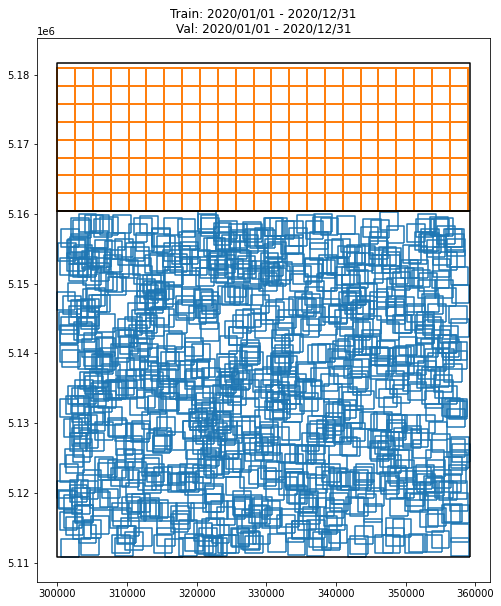

In [8]:
train_roi = data.train_dataloader().sampler.roi
val_roi = data.val_dataloader().sampler.roi

plt.figure(figsize=(10, 10))
ax = plt.gca()
gpd.GeoSeries([bbox_to_shapely(b) for b in data.train_dataloader().sampler]).boundary.plot(ax=ax, color="C0")
gpd.GeoSeries([bbox_to_shapely(b) for b in data.val_dataloader().sampler]).boundary.plot(ax=ax, color="C1")
gpd.GeoSeries(bbox_to_shapely(train_roi)).boundary.plot(ax=ax, color="black")
gpd.GeoSeries(bbox_to_shapely(val_roi)).boundary.plot(ax=ax, color="black")
plt.title(
    f"Train: {format_timestamp(train_roi.mint)} - {format_timestamp(train_roi.maxt)}\n"
    f"Val: {format_timestamp(val_roi.mint)} - {format_timestamp(val_roi.maxt)}"
)
plt.show()

### Model Definition

We will train a Unet that receives the stacked NDVI rasters and outputs a crop segmentation map. To optimize our model, we employ pixel-wise cross-entropy loss between the network's prediction and the CDL map for the same chip.

The `SegmentationModel` defines the network architecture and training parameters. It has the following arguments:

- `lr`: learning rate.
- `weight_decay`: amount of weight decay regularization.
- `in_channels`: number of input channels of the network. Needs to match the number of bands/channels of the stacked NVDI raster.
- `encoder_name`: name of the encoder used for the Unet. See segmentation_models_pytorch for more information. Default: 'resnet34'
- `encoder_weights`: name of the pretrained weights for the encoder. Use 'imagenet' or None (random weights). See [segmentation_models_pytorch](https://smp.readthedocs.io/en/latest/index.html) for more information. Default: 'imagenet'
- `classes`: number of output classes. As we are doing a binary crop vs. non-crop segmentation, we use the default value. Default: 1
- `num_epochs`: number of training epochs. Used for the cosine annealing scheduler. Default: 10


When training for specific crops you might want to tune the loss (specifically due to imbalance, the amount of positive pixels will be really small compared to negative ones). Feel free to play around with other parameters such as learning rate, weight decay, etc.

In [9]:
model = SegmentationModel(lr=LR, 
                        weight_decay=WD, 
                        in_channels=NDVI_STACK_BANDS,
                        num_epochs=MAX_EPOCHS,
                        classes=1,
                        )

# Default checkpoint callback will save a checkpoint at the end of every epoch
callbacks = [ModelCheckpoint()]

# Change to gpus=0 to run on CPU
trainer = Trainer(max_epochs=MAX_EPOCHS, callbacks=callbacks, default_root_dir=ROOT_DIR, gpus = 0)

/home/azureuser/anaconda3/envs/crop-seg/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training
We can train the model by calling the trainer's fit method and passing the lightning module and data module.

In [10]:
if CHPT_PATH and os.path.exists(CHPT_PATH):
    # Load model
    model = SegmentationModel.load_from_checkpoint(CHPT_PATH)
else:
    # Train it now
    trainer.fit(model, data)


  | Name          | Type              | Params
----------------------------------------------------
0 | model         | FPN               | 23.3 M
1 | loss          | BCEWithLogitsLoss | 0     
2 | train_metrics | MetricCollection  | 0     
3 | val_metrics   | MetricCollection  | 0     
----------------------------------------------------
23.3 M    Trainable params
0         Non-trainable params
23.3 M    Total params
93.048    Total estimated model params size (MB)


Converting CDLMask CRS from EPSG:5070 to EPSG:32611
Converting CDLMask resolution from 30.0 to 10.0


Sanity Checking: 0it [00:00, ?it/s]

/home/azureuser/anaconda3/envs/crop-seg/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/azureuser/anaconda3/envs/crop-seg/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:98: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/home/azureuser/anaconda3/envs/crop-seg/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of th

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/azureuser/anaconda3/envs/crop-seg/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:98: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


### Evaluation
We can evaluate the model by calling the validate method from the Pytorch-Lightning trainer. This will compute and print metrics for the validation set. Additionally, we plot the Precision-Recall curve, and display the operating point for a threshold of 0.5.

In [13]:
trainer.validate(model, data)

Converting CDLMask CRS from EPSG:5070 to EPSG:32611
Converting CDLMask resolution from 30.0 to 10.0


/home/azureuser/anaconda3/envs/crop-seg/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9227107763290405     │
│          val_ap           │     0.960536003112793     │
│         val_loss          │    0.19294773042201996    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.19294773042201996,
  'val_acc': 0.9227107763290405,
  'val_ap': 0.960536003112793}]

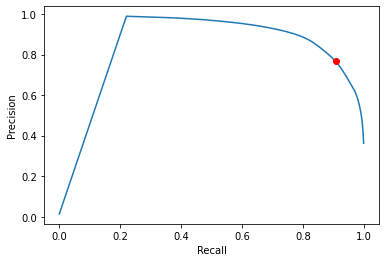

In [14]:
FPs = model.val_metrics["ap"].FPs
TPs = model.val_metrics["ap"].TPs
FNs = model.val_metrics["ap"].FNs

Re = TPs / (TPs + FNs)
Pr = TPs / (TPs + FPs)

plt.plot(Re[0], Pr[0])
plt.plot(Re[0, 50], Pr[0, 50], 'ro')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

### Saving the model to ONNX format

[Open Neural Network Exchange](https://onnx.ai/) (ONNX) is a open source format that represents machine learning models, both deep learning and traditional ML. It is supported by many frameworks, tools and hardware, enabling interoperability between different components easily. Exporting our trained model in ONNX format allows us to load it and perform inference over new data under different hardware setups and even within FarmVibes.AI platform. For additional resources, refer to the [ONNX](https://onnx.ai/get-started.html) or [PyTorch](https://pytorch.org/docs/master/onnx.html) documentations.

In [15]:
import torch.nn as nn

# Trace the model with sigmoid activation
class ModelPlusSigmoid(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        return self.model(x).sigmoid()

# Set model to inference mode before exporting to ONNX
trace_model = ModelPlusSigmoid(model).eval()    

dummy_input = torch.randn(BATCH_SIZE, NDVI_STACK_BANDS, CHIP_SIZE, CHIP_SIZE)

onnx_output_path = os.path.join(ROOT_DIR, "crop_segmentation_model.onnx")

# Export the model
torch.onnx.export(trace_model,                                            
                  dummy_input,                                           # model example input
                  onnx_output_path,                                      # where to save the model (can be a file or file-like object)
                  export_params=True,                                    # store the trained parameter weights inside the model file
                  do_constant_folding=True,                              # whether to execute constant folding for optimization
                  input_names=['ndvi_stack'],                            # the model's input names
                  output_names=['seg_map'],                              # the model's output names
                  dynamic_axes={'ndvi_stack' : {0 : 'batch_size'},       # variable length axes
                                'seg_map' : {0 : 'batch_size'}}) 

/home/azureuser/anaconda3/envs/crop-seg/lib/python3.8/site-packages/torch/nn/functional.py:2515: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  _verify_batch_size([input.size(0) * input.size(1) // num_groups, num_groups] + list(input.size()[2:]))


Let's use ONNX checker to verify the model was exported successfully: 

In [16]:
onnx_model = onnx.load(onnx_output_path)
onnx.checker.check_model(onnx_model)

# Perform inference in the cluster
First, we need to add the model to the cluster. This can be done using the `farmvibes_ai.sh` script, for more information, see the [script documentation](../../documentation/FARMVIBES_SCRIPT.md).
Files added via the script will be available to the worker at `/mnt/onnx-resources`.

In [17]:
# Run command to add model to the cluster. You can also run this on a terminal
!bash ../../farmvibes-ai.sh add-onnx $onnx_output_path

In [ ]:
client.document_workflow("ml/crop_segmentation")

In [20]:
# Run inference in the validation region
inference_geom = gpd.GeoSeries(bbox_to_shapely(val_roi), crs=data.val_dataset.crs).to_crs("epsg:4326").iloc[0]
inference_run = client.run(
    "ml/crop_segmentation",
    "Crop segmentation inference",
    geometry=geometry,
    time_range=time_range,
    # Set the path to our model
    parameters={"model_file": "/mnt/onnx_resources/crop_segmentation_model.onnx"}
)
inference_run.monitor()

Output()

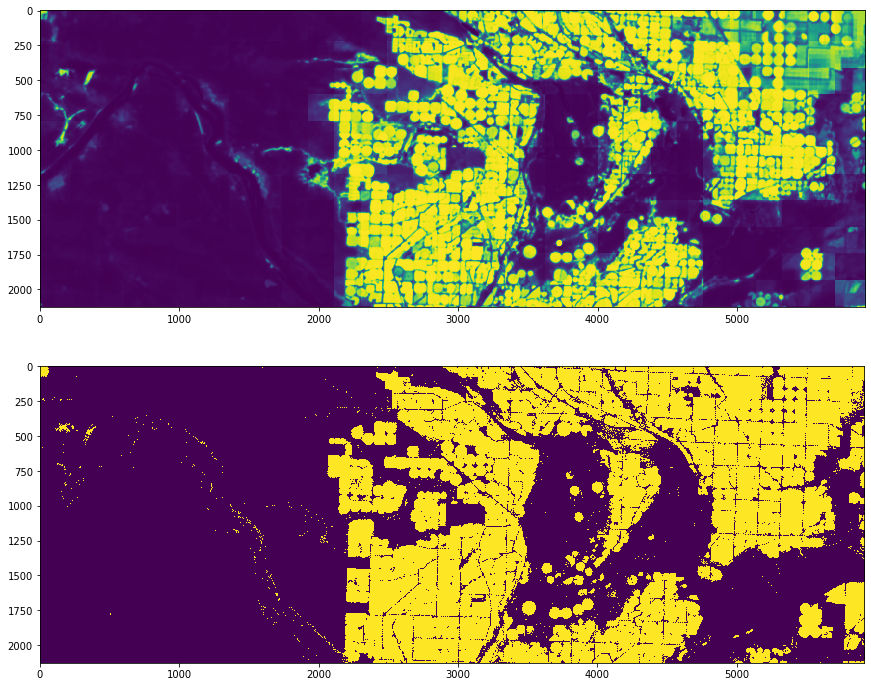

In [21]:
# Get the ground-truth data
gt_ar = data.val_dataset[val_roi]["mask"][0].numpy()
# Read inference results
with rasterio.open(inference_run.output["segmentation"][0].raster_asset.url) as src:
    data_ar = src.read(1)
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.imshow(data_ar[:int(data_ar.shape[0]*.3)], interpolation="none")
plt.subplot(2, 1, 2)
plt.imshow(gt_ar, interpolation="none")
plt.show()